***
# 5. Bonus : Application de la méthode à un exemple dynamique
***

# Objectif de la partie : amorcer une approche vers une simulation.

## Note sur cette partie bonus
Cette section vient en complément du projet de base qui a été réalisé avant la période des partiels du S3B. La date de rendu étant repoussée au-delà. Il me restait un peu de temps pour pouvoir essayer d'aller plus loin dans ce projet. Notamment de voir comment on pourrait intégrer la méthode tau dans le cas dynamique. Sans utiliser Dedalus, l'implémentation de la méthode m'a été beaucoup plus difficile que je pensais. Vous trouverez dans la suite le peu que j'ai réussi à faire.

## Ce que nous avons fait jusque-là
Jusque-là, nous avons mis sous le tapis, les dépendances temporelles de la fonction étudiée. Lorsque l'on va vouloir réaliser des simulations numériques cette dépendance est bien sûr primordiale. Nous allons essayer de voir comment cela s'implique avec la méthode tau.

L'objectif de cette partie est de réussir à faire une simulation d'un exemple dynamique simple sans utiliser directement Dedalus qui est encore une grosse boite noire.

L'objectif ici n'est pas de devoir commenter comment la dépendance temporelle est gérée par Dedalus, mais plutôt de voir comment intégrer la méthode tau si il y a une indépendance temporelle.

## Cadre : à la recherche de simplicité

Comme nous avons déjà étudié les dérivées du premier ordre, nous allons étudier l'équation la plus simple qu'il soit : l'équation de transport.

### L'équation de transport

L'**équation du transport**, également connue sous le nom d'équation d'advection, est une équation aux dérivées partielles qui décrit le transport d'une quantité conservée par un champ de vecteurs. Elle s'exprime généralement comme suit en une dimension spatiale :

$$ \frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0,$$

où :
- $ u(x, t) $ est la fonction inconnue dépendant du temps $ t $ et de la position $ x $,
- $ c $ est la vitesse constante du transport.

Cette équation représente la conservation de la quantité $ u $ le long des trajectoires définies par le champ de vecteurs $ c $.

### Les différentes conditions aux limites possibles

Nous allons étudier la propagation d'une onde dans deux cas :
- une boîte périodique, le développement dans la base de Fourier sera donc le plus adapté
- une boîte fermée, ce type de boîte impose des conditions aux limites particulières que l'on implémentera avec la méthode tau dans la base des polynômes de Chebysev.

On note $L$ La longueur de cette boîte.

### Conditions initales 
On prendra comme condition initiale, une fonction porte.

# Cas d'une boîte aux conditions aux limites périodiques

## Étapes de la résolution : méthode spectrale classique 

### 1. Discrétisation spatiale :
Comme nous avons seulement explicité la méthode jusque-là, et que nous ne l'avons pas appliquée à un cas concret, nous avions mis sous le tapis la discrétisation du domaine spatial. C'est une étape nécessaire à toute simulation numérique.

#### Choix
Dans le cas de la base de Fourier, la discrétisation efficace est celle d'une discrétisation équirépartie des $N$ points dans la direction spatiale.
$$ x_n = \frac{n}{L}, \quad n = 0, 1, 2, \ldots, N-1.$$
On note alors :
$$u_n = u(t, x_n).$$


### 2. Décomposition et projection dans la base de Fourier, `FFT`


Pour simplifier l'implémentation numérique, nous utiliserons ici la notation non matricielle, bien que la notation matricielle soit également possible.

On décompose et projette dans la base de Fourier, ce qui revient à réaliser une Transformée de Fourier (TF). On note

$$ \hat{u}_m = \sum_{n=0}^{N-1} u_n \langle\phi_m(x)|\phi_n(x)\rangle \text{ avec }
\phi_n(x) = \frac{1}{\sqrt{L}} e^{i k_n x},\quad k_n =\frac{2\pi n}{L}.
$$

L'équation se réécrit alors après simplification :
$$
\partial_t \hat{u}_m = -i k_m c \hat{u}_m.
$$

Pour effectuer une transformée de Fourier sur n'importe quelle fonction de manière simple, on peut utiliser l'outil `FFT` déjà implémenté en Python. 

### 3. Résolution temporelle

On reconnaît une simple équation d'ordre un que l'on peut parfaitement résoudre avec une solution de la forme exponentielle. On peut généraliser ce résultat en utilisant des outils Python tels que la fonction `odeint` de `scipy`, qui permet de résoudre tout système de la forme :
$$
\partial_t u = f(u,t).
$$


### 4. Transformée inverse de Fourier :

On applique la transformée de Fourier inverse (TFI) pour revenir au domaine spatial et obtenir la solution $u_n$ à chaque point.

### 5. Répétition pour chaque étape temporelle :
On réitère l'ensemble de ces étapes pour chaque instant de temps.


## Résultats de la simulation : concluant

Condition CFL respectée


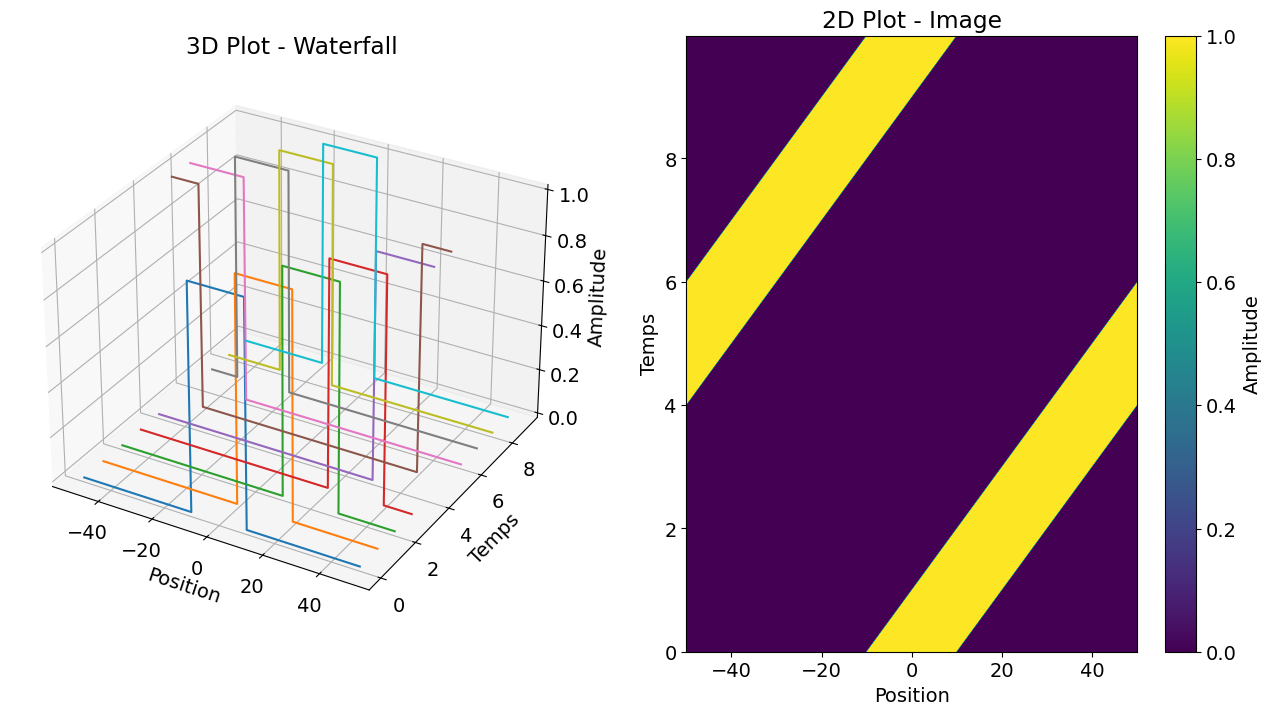

In [15]:
"""
Simulation de la propagation d'une fonction porte par l'équation de transport dans le cas d'une boîte périodique.
"""


import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import axes3d

# Définition des paramètres et des configurations graphiques
plt.rcParams['figure.figsize'] = [16, 8]  # Ajustement de la taille de la figure
plt.rcParams.update({'font.size': 14})

c = 10  # vitesse de l'onde
L = 100  # Longueur du domaine
N = 1000  # Nombre de points de discrétisation
dx = L / N
x = np.arange(-L / 2, L / 2, dx)  # Définition du domaine x

# Définition des nombres d'onde discrets
kappa = 2 * np.pi * np.fft.fftfreq(N, d=dx)

# Condition initiale
u0 = np.zeros_like(x)
u0[int((L / 2 - L / 10) / dx):int((L / 2 + L / 10) / dx)] = 1
u0hat = np.fft.fft(u0)

# La fonction odeint de SciPy ne fonctionne pas bien avec les nombres complexes,
# nous recastons donc l'état u0hat d'un vecteur complexe de N éléments à un vecteur réel de 2N éléments
u0hat_ri = np.concatenate((u0hat.real, u0hat.imag))
###
# Simulation dans le domaine fréquentiel de Fourier
###
dt = 0.01
t = np.arange(0, 10, dt)

# Vérification de la condition CFL
if c * dt <= dx:
    print("Condition CFL respectée")
else:
    print("Condition CFL NON respectée")

# Calcul du terme de droite RHS
def rhs(uhat_ri, t, kappa, a):
    uhat = uhat_ri[:N] + (1j) * uhat_ri[N:]
    d_uhat = -c * (1j) * kappa * uhat
    d_uhat_ri = np.concatenate((d_uhat.real, d_uhat.imag)).astype('float64')
    return d_uhat_ri

uhat_ri = odeint(rhs, u0hat_ri, t, args=(kappa, c))

uhat = uhat_ri[:, :N] + (1j) * uhat_ri[:, N:]

u = np.zeros_like(uhat)

# Transformation inverse de Fourier
for k in range(len(t)):
    u[k, :] = np.fft.ifft(uhat[k, :])

u = u.real

# Tracé en 3D (Waterfall plot)
fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')  # Ajout d'un subplot pour le deuxième graphique

u_plot = u[0:-1:100, :]
for j in range(u_plot.shape[0]):
    ys = j * np.ones(u_plot.shape[1])
    ax.plot(x, ys, u_plot[j, :])

ax.set_xlabel('Position')
ax.set_ylabel('Temps')
ax.set_zlabel('Amplitude')
ax.set_title('3D Plot - Waterfall')

# Tracé en 2D (Image plot)
plt.subplot(122)  # Utilisation du deuxième subplot
plt.imshow(np.flipud(u), aspect='auto', extent=[-L / 2, L / 2, 0, t[-1]])
plt.colorbar(label='Amplitude')
plt.xlabel('Position')
plt.ylabel('Temps')
plt.title('2D Plot - Image')
plt.show()


In [10]:
"""
Affichage dynamique de la simulation
"""

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np

# Sélectionner un sous-ensemble de données pour l'affichage dynamique
u_plot = u[0:-1:10, :]

# Créer une nouvelle figure pour les tracés 2D
fig, ax = plt.subplots(figsize=(10, 6), dpi=80)

# Initialiser la ligne que nous mettrons à jour dans l'animation
line, = ax.plot(x, u_plot[0, :], label=f'Courbe 1')

# Ajouter des étiquettes, une légende, etc.
ax.set_xlabel('$x$')
ax.set_ylabel('$u$')
plt.title('Animation des tracés 2D de $u$')

# Fonction d'animation qui sera appelée à chaque frame
def update(frame):
    line.set_ydata(u_plot[frame, :])
    return line,

# Créer l'animation
animation_interval = 200  # Interval entre les frames en millisecondes
ani = animation.FuncAnimation(fig, update, frames=u_plot.shape[0], interval=animation_interval, blit=True)

# Enregistrer l'animation au format HTML5
html5_video = ani.to_jshtml()

# Fermer la figure pour éviter un affichage indésirable dans le notebook
plt.close()

# Afficher l'animation dans le notebook
HTML(html5_video)


## Commentaires

Les résultats de la simulation correspondent parfaitement aux attentes pour le scénario de la fonction porte propulsée par l'équation de transport dans des conditions périodiques. On observe une propagation inaltérée du paquet d'ondes, sans aucune déformation, ce qui est conforme aux prévisions théoriques.

# Cas d'une boîte fermée

Si l'on prend l'exemple de la propagation d'une onde le long d'une corde, en supposant une boîte fermée, nous devons imposer une amplitude nulle aux extrémités. Ainsi, nous cherchons à mettre en œuvre les conditions aux limites suivantes :
$$ u\left(-\frac{L}{2},t\right) = 0 \quad \text{et} \quad u\left(\frac{L}{2},t\right) = 0. $$

Étant donné que les conditions aux limites ne sont plus périodiques, nous sommes contraints d'utiliser la méthode Galerkin avec la méthode tau et le préconditionnement de Dirichlet pour résoudre le problème de manière appropriée. 

On va donc résoudre l'équation adimensionnée suivante :
$$ \frac{\partial u}{\partial x} + \tau U_{N-1}(x)= \frac{\partial u}{\partial t}, \quad u(-1) = 0 \text{ et } u(1) = 0.$$
Avec comme choix : 
- base d'essaie : $|\phi_n(x)\rangle = D_n(x)$ avec son produit scalaire $ \langle ., . \rangle_1$,
- base de test et polynôme ajouté : $|\psi_n(x)\rangle = U_n(x)$ avec son produit scalaire $ \langle ., . \rangle_2$.

## Étapes de la résolution : méthode tau

### 1. Discrétisation spatiale :

Dans le cas de Chebysev, la discrétisation efficace est celle de la discrétisation pariculière suivante :
$$ x_n = \frac{L}{2} \cos\left(\frac{(2 n - 1)\pi }{2N}\right), \quad n = 0, 1, 2, \ldots, N-1.$$
On note alors :
$$u_n = u(t, x_n).$$

### 2. Décomposition et projection dans les bases de Chebysev, `DCT`

On applique la méthode de Galerkin, on note :

$$ \hat{u}_m = \sum_{n=0}^{N-1} u_n \langle U_m(x)|D_n(x)\rangle.
$$

L'équation se réécrit alors après simplification (voir calcul sur le PDF : calcul.pdf), si $m$ est pair :
$$
\partial_t \hat{u}_m = \sum_{n=0}^{N-1} u_n \langle U_m(x)|L|D_n(x)\rangle = -m(\hat{u}_0+...+\hat{u}_{m-2}),
$$
et si $m$ est impair :
$$
\partial_t \hat{u}_m = \sum_{n=0}^{N-1} u_n \langle U_m(x)|L|D_n(x)\rangle = \partial_t \hat{u}_1 -m(\hat{u}_1+...+\hat{u}_{m-2}).
$$

Pour effectuer une transformée de Chebysev sur n'importe quelle fonction de manière simple, on peut utiliser l'outil `DCT` (Discrete Chebyshev transform) déjà implémenté en Python. 

***
**Remarque : Premier problème, erreur de calcul ?**

Si le calcul réalisé est bon alors $\partial_t \hat{u}_1$ est indeterminé. On le fixera à zéro.
***

### 3. Ajout des condtions aux limites

Avec la méthode tau, ajouter les conditions aux limites revient à supprimer les deux derniers termes de la transformeée et de remplacer les équations obtenus par les équations des conditions aux limites. On utilise ici les propriétés pratiques du préconditionnement de Dirichlet.


### 4. Résolution temporelle

On a la même chose que pour le cas Fourier.

### 5. Transformée inverse de Chebysev :

On applique la transformée de Chebysev inverse (DCTI) pour revenir au domaine spatial et obtenir la solution $u_n$ à chaque point.

### 6. Répétition pour chaque étape temporelle :
On réitère l'ensemble de ces étapes pour chaque instant de temps.

## Résultats de la simulation : décevant

Condition CFL respectée


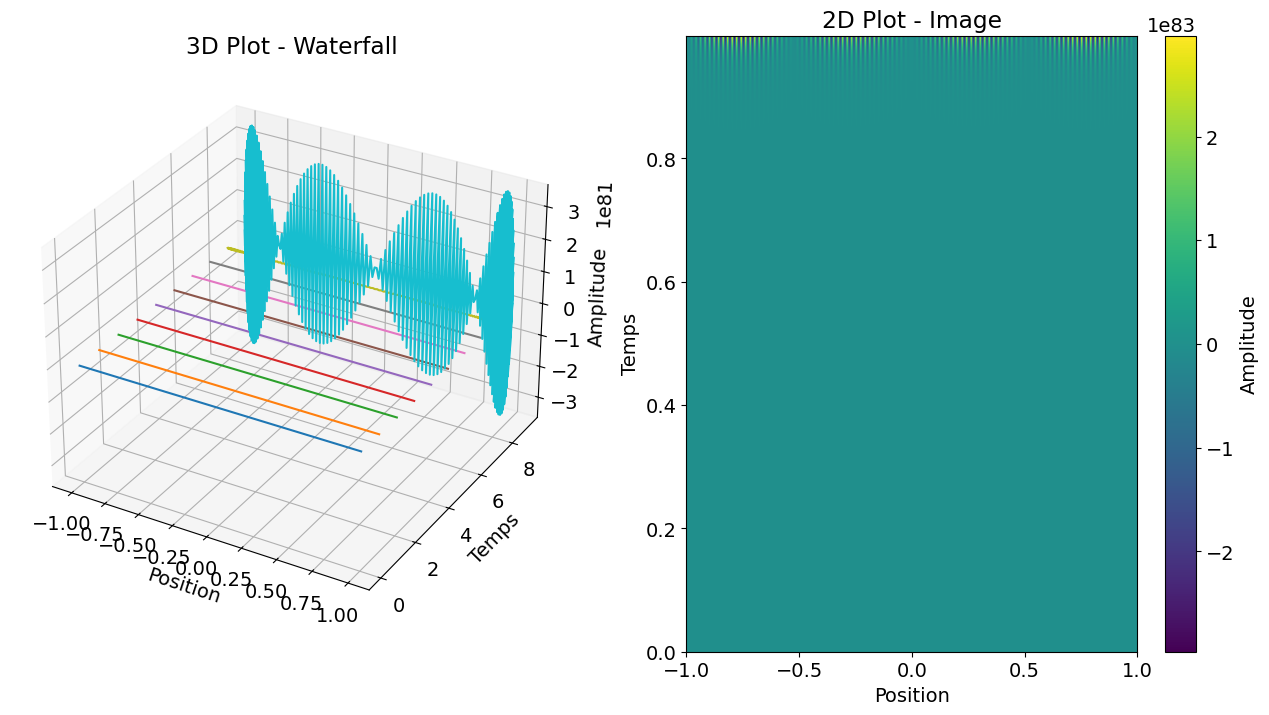

In [54]:
"""
Simulation de la propagation d'une fonction porte par l'équation de transport dans le cas d'une boîte fermé.
On écrit ### les différences avec le cas périodiques.
"""

import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import axes3d

# Définition des paramètres et des configurations graphiques
plt.rcParams['figure.figsize'] = [16, 8]  # Ajustement de la taille de la figure
plt.rcParams.update({'font.size': 14})

c = 10  # vitesse de l'onde
L = 2  # Longueur du domaine pour avoir bornes en -1 et 1
N = 200  # Nombre de points de discrétisation
dx = L / N
x = L / 2 * np.cos((2 * np.arange(1, N + 1) - 1) * np.pi / (2 * N))  # Définition du domaine x

# Condition initiale
u0 = np.zeros_like(x)
u0[int(N/2-20):int(N/2+20)] = 1
u0hat = sc.fft.dct(u0)

###
# Simulation dans le domaine fréquentiel de Chebysev
###

dt = 0.001
t_max = 1
N_t = int(t_max / dt)
t = np.arange(0, t_max, dt)

# Vérification de la condition CFL
if c * dt <= dx:
    print("Condition CFL respectée")
else:
    print("Condition CFL NON respectée")

# Calcul du terme de droite RHS
def rhs(uhat, t, c):
    d_uhat = np.zeros_like(uhat)
    for m in range(2, N - 1):
        if m % 2 == 0:
            d_uhat[m] = -c * (-m) * np.sum(uhat[:m - 2:2])
        else:
            d_uhat[m] = -c * (-m) * np.sum(uhat[1:m - 2:2])
    return d_uhat

uhat = odeint(rhs, u0hat, t, args=(c,))


# Rempalcment terme tau 
uhat[:, N-1] = np.zeros(N_t)
uhat[:, N-2] = np.zeros(N_t)

uhat[0, N-1] = 1
uhat[1, N-1] = 1

uhat[0, N-2] = 1
uhat[1, N-2] = -1


u = np.zeros_like(uhat)

# Transformation inverse de Chebysev
for k in range(len(t)):
    u[k, :] = sc.fft.idct(uhat[k, :])

# Tracé en 3D (Waterfall plot)
fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')  # Ajout d'un subplot pour le deuxième graphique

u_plot = u[0:-1:100, :]
for j in range(u_plot.shape[0]):
    ys = j * np.ones(u_plot.shape[1])
    ax.plot(x, ys, u_plot[j, :])

ax.set_xlabel('Position')
ax.set_ylabel('Temps')
ax.set_zlabel('Amplitude')
ax.set_title('3D Plot - Waterfall')

# Tracé en 2D (Image plot)
plt.subplot(122)  # Utilisation du deuxième subplot
plt.imshow(np.flipud(u), aspect='auto', extent=[-L / 2, L / 2, 0, t[-1]])
plt.colorbar(label='Amplitude')
plt.xlabel('Position')
plt.ylabel('Temps')
plt.title('2D Plot - Image')
plt.show()


In [57]:
"""
Affichage dynamique de la simulation
"""

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np

# Sélectionner un sous-ensemble de données pour l'affichage dynamique
u_plot = u[0:-1:10, :]

# Créer une nouvelle figure pour les tracés 2D
fig, ax = plt.subplots(figsize=(10, 6), dpi=80)

# Initialiser la ligne que nous mettrons à jour dans l'animation
line, = ax.plot(x, u_plot[0, :], label=f'Courbe 1')

# Ajouter des étiquettes, une légende, etc.
ax.set_xlabel('$x$')
ax.set_ylabel('$u$')
plt.title('Animation des tracés 2D de $u$')

# Fonction d'animation qui sera appelée à chaque frame
def update(frame):
    line.set_ydata(u_plot[frame, :])
    return line,

# Créer l'animation
animation_interval = 200  # Interval entre les frames en millisecondes
ani = animation.FuncAnimation(fig, update, frames=u_plot.shape[0], interval=animation_interval, blit=True)

# Enregistrer l'animation au format HTML5
html5_video = ani.to_jshtml()

# Fermer la figure pour éviter un affichage indésirable dans le notebook
plt.close()

# Afficher l'animation dans le notebook
HTML(html5_video)


***
**Remarque : Second problème, une erreur dans le code ?**

La simulatino ne donne pas de bons résultats du tout.
***

## Commentaires

Le comportement attendu était une onde se propageant à travers la boîte, rebondissant sur les bords. Cependant, les résultats obtenus diffèrent considérablement de cette attente. L'application de notre méthode n'a pas abouti, suggérant une possible défaillance dans le code que j'ai développé. Il est probable que des erreurs d'implémentation ou de calcul soient à l'origine du problème, signalant ainsi une nécessité de réexaminer la compréhension de la méthode ou de corriger d'éventuelles erreurs dans le code.

# Résumé de cette partie

### Objectif de la partie

L'objectif de cette section était de mettre en œuvre la méthode décrite dans le contexte d'une simulation simple.

### Cas Périodique

L'implémentation de la méthode spectrale dans le cas périodique s'est avérée être une réussite, produisant des résultats conformes aux attentes.

### Cas Non Périodique

En revanche, pour le cas non périodique, la simulation présente des anomalies significatives. Il devient crucial d'identifier l'origine de cette erreur afin d'acquérir une compréhension approfondie du fonctionnement de la méthode dans ce contexte particulier.



***
**Remarques : Notes personnelles** 

Cette section m'a quelque peu frustré. Mes ambitions initiales étaient plutôt élevées, visant à aborder la résolution de l'équation de Burger. Mon objectif était de démontrer que dans le cas périodique, le soliton se propage indéfiniment, tandis que dans le cas d'une boîte fermée, il rebondit. Cependant, je me suis rendu compte qu'il serait plus simple et conceptuellement plus clair de traiter cet exemple de manière plus élémentaire. 

Je suis motivé à comprendre mes erreurs et à approfondir ma compréhension du projet Dedalus. Bien que le projet réalisé dans le cadre de ce cours m'ait apporté une compréhension significative, il a également mis en lumière la présence de nombreuses zones encore floues pour moi.
***

***
**Remarques : Termes non linéaires**
Je n'ai pas traité la manière d'aborder les termes non linéaires dans le contexte d'une méthode spectrale. Cependant, j'ai examiné cette problématique, en particulier lors de ma tentative de résolution de l'équation de Burger. Un point crucial à souligner est que, lorsque des termes non linéaires entrent en jeu, il est souvent plus efficace de sortir du domaine spectral pour le calcul du produit de ces termes. Il est moins coûteux de réaliser une transformée de Fourier inverse pour calculer le produit, puis de refaire une transformée de Fourier que de calculer directement la transformée de Fourier du produit, ce qui implique un produit de convolution.

***